In [1]:
# Cell 1 — imports & PYTHONPATH
import sys
from pathlib import Path
import random

import torch
import torch.nn.functional as F
from torch import optim
import numpy as np

# project setup
PROJECT_ROOT = Path('..').resolve()
sys.path.append(str(PROJECT_ROOT / 'src'))

from utils      import load_image, load_mask, compute_vector_field
from engine     import AntEnv
from model      import AntModel


In [2]:
# Cell 2 — helper to pack obs into tensors
def pack_inputs(patch_np, memory, device):
    pt = torch.from_numpy(patch_np.astype(np.float32)/255)\
              .permute(2,0,1).unsqueeze(0).to(device)
    mem_t = []
    for p_np, a_np in memory:
        p_t = torch.from_numpy(p_np.astype(np.float32)/255)\
                  .permute(2,0,1).to(device)
        a_t = torch.from_numpy(a_np.astype(np.float32)).to(device)
        mem_t.append((p_t, a_t))
    return pt, mem_t


In [3]:
# Cell 3 — Agent wrapper
class Agent:
    def __init__(self, device, img, mask, vf):
        self.env = AntEnv(img, mask, vf, kernel_size=(16,16), memory_len=50, max_steps=200)
        self.model = AntModel(in_channels=3, patch_size=(16,16), emb_dim=128, n_actions=8, n_heads=4).to(device)
        self.opt   = optim.Adam(self.model.parameters(), lr=1e-4)
        self.energy = 50
        # initialize obs + memory
        self.obs_patch, self.mem = self.env.reset()

    def step_and_learn(self, device):
        # forward
        pt, mem_t = pack_inputs(self.obs_patch, self.mem, device)
        logits    = self.model(pt, mem_t)
        dist      = torch.distributions.Categorical(logits=logits)
        action    = dist.sample()
        logp      = dist.log_prob(action)

        # env step
        (obs2, mem2), _, done, _ = self.env.step(int(action.item()))

        # energy update
        delta = 1 if self.env.is_in_cell() else -1
        self.energy += delta

        # one‐step policy‐gradient update
        loss = - logp * delta
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # store next obs for next step
        self.obs_patch, self.mem = obs2, mem2

        return done


In [4]:
# Cell 4 — load data & initialize 10 agents
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use the same image/mask for all ants
img_path  = PROJECT_ROOT / 'data/Fold1_jpg/images/1.jpg'
mask_path = PROJECT_ROOT / 'data/Fold1_jpg/masks/1.jpg'
img  = load_image(str(img_path))
mask = load_mask(str(mask_path))
vf   = compute_vector_field(mask)

# spawn population
N = 10
agents = [Agent(device, img, mask, vf) for _ in range(N)]


In [5]:
# Cell 5 — evolutionary / energy loop with automatic best‐model saving

global_step = 0
LOG_INTERVAL = 10
best_energy = -float('inf')
best_agent = None

try:
    while True:
        global_step += 1

        # step & learn for each agent
        for i, ag in enumerate(agents):
            ag.step_and_learn(device)

            # track best so far
            if ag.energy > best_energy:
                best_energy = ag.energy
                best_agent = ag

            # respawn if dead
            if ag.energy <= 0:
                agents[i] = Agent(device, img, mask, vf)

            # stop early if someone masters
            if ag.energy >= 5000:
                print(f"🏆 Agent {i} reached {ag.energy} energy at step {global_step}!")
                raise SystemExit

        # periodic logging
        if global_step % LOG_INTERVAL == 0:
            energies = [int(a.energy) for a in agents]
            best_idx = energies.index(max(energies))
            last_positions = agents[best_idx].env.trajectory[-10:]
            print(f"[Step {global_step:05d}] Energies: {energies}")
            print(f"  ▶ Best Agent #{best_idx} last 10 positions: {last_positions}")

except KeyboardInterrupt:
    print(f"🔴 Training manually interrupted at step {global_step}.")

finally:
    import os
    os.makedirs('Agents', exist_ok=True)
    for idx, ag in enumerate(agents):
        path = f'Agents/agent_{idx}.pth'
        torch.save(ag.model.state_dict(), path)
    print(f"💾 Saved all {len(agents)} agent models into 'Agents/'")


[Step 00010] Energies: [40, 40, 40, 40, 40, 40, 40, 40, 40, 40]
  ▶ Best Agent #0 last 10 positions: [(154, 250), (159, 245), (154, 245), (159, 250), (154, 250), (149, 255), (154, 250), (154, 255), (149, 4), (154, 9)]
[Step 00020] Energies: [30, 30, 30, 30, 30, 30, 42, 30, 30, 30]
  ▶ Best Agent #6 last 10 positions: [(231, 121), (226, 116), (226, 111), (221, 106), (216, 111), (211, 106), (206, 106), (201, 101), (206, 106), (201, 111)]
[Step 00030] Energies: [20, 20, 20, 20, 20, 20, 34, 20, 20, 20]
  ▶ Best Agent #6 last 10 positions: [(196, 116), (196, 111), (201, 116), (206, 121), (211, 126), (216, 131), (221, 136), (221, 141), (216, 141), (211, 136)]
[Step 00040] Energies: [10, 10, 10, 18, 10, 10, 24, 10, 10, 10]
  ▶ Best Agent #6 last 10 positions: [(211, 141), (206, 141), (211, 146), (206, 141), (211, 141), (211, 136), (216, 136), (221, 131), (226, 131), (221, 126)]
[Step 00050] Energies: [50, 50, 50, 26, 50, 50, 14, 6, 50, 50]
  ▶ Best Agent #0 last 10 positions: [(74, 73)]
[Step

TypeError: AntEnv.__init__() got an unexpected keyword argument 'boundary'

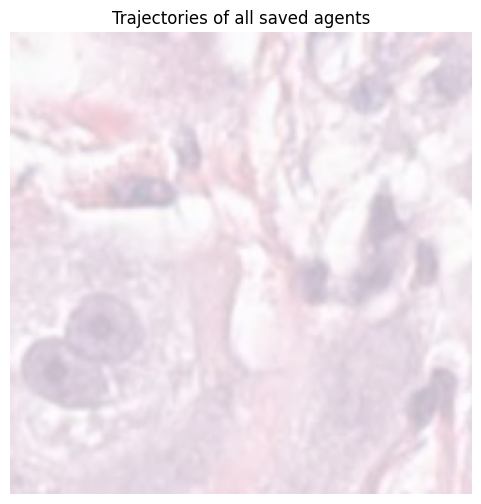

In [7]:
# Cell 7 — Visualize trajectories of all saved agents (no wrap‐line artifacts)

import glob
import matplotlib.pyplot as plt
import numpy as np

model_paths = sorted(glob.glob('Agents/agent_*.pth'))

plt.figure(figsize=(6,6))
# show background once
plt.imshow(img, alpha=0.3)
plt.axis('off')
plt.title('Trajectories of all saved agents')

for mp in model_paths:
    # load model
    model = AntModel(in_channels=3, patch_size=(16,16),
                     emb_dim=128, n_actions=8, n_heads=4).to(device)
    model.load_state_dict(torch.load(mp, map_location=device))
    model.eval()

    # fresh torus‐wrapped env
    eval_env = AntEnv(img, mask, vf,
                      kernel_size=(16,16),
                      memory_len=100,
                      max_steps=500,
                      boundary='torus')
    obs_patch, mem = eval_env.reset()

    # rollout greedy for up to 500 steps
    for _ in range(500):
        pt, mem_t = pack_inputs(obs_patch, mem, device)
        with torch.no_grad():
            logits = model(pt, mem_t)
        action = int(logits.argmax(dim=-1).item())
        (obs_patch, mem), _, done, _ = eval_env.step(action)
        if done:
            break

    traj = np.array(eval_env.trajectory)  # shape (T,2)
    xs, ys = traj[:,0], traj[:,1]

    # split into continuous segments wherever a wrap‐jump occurred
    segments = []
    cur_x, cur_y = [xs[0]], [ys[0]]
    for (x0,y0), (x1,y1) in zip(traj[:-1], traj[1:]):
        if abs(x1 - x0) > 1 or abs(y1 - y0) > 1:
            # a wrap‐jump: finish current segment
            segments.append((cur_x, cur_y))
            cur_x, cur_y = [x1], [y1]
        else:
            cur_x.append(x1)
            cur_y.append(y1)
    segments.append((cur_x, cur_y))

    # plot each segment in the same color
    for sx, sy in segments:
        plt.plot(sx, sy, linewidth=1, alpha=0.7, color='blue')

plt.tight_layout()
plt.show()
